In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D

In [11]:
dataset_dir= r"C:\Users\Kishore K\Downloads\AICET_WEAK_2_GarbageCollection-master\AICET_WEAK_2_GarbageCollection-master\archive\TrashType_Image_Dataset"

image_size = (124, 124)

batch_size = 32

seed = 42

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(

dataset_dir,

validation_split=0.2,

subset="training",

seed=seed,

shuffle = True,

image_size=image_size,

batch_size=batch_size

)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(

dataset_dir,

validation_split=0.2,

subset="validation",

seed=seed,

shuffle = True,

image_size=image_size,

batch_size=batch_size

)

val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [14]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [15]:
print(train_ds.class_names)

print(val_class)

print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


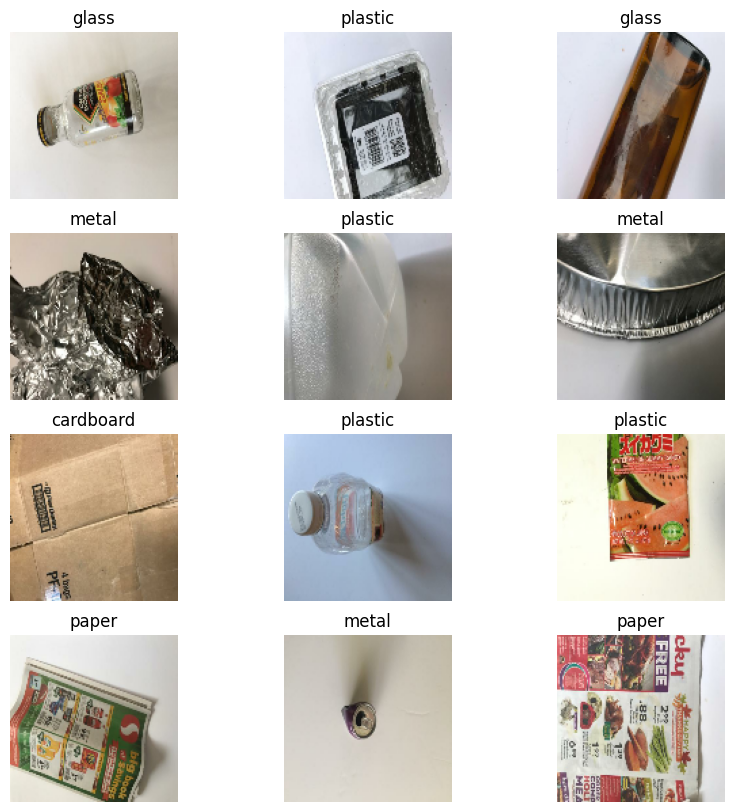

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

plt.show()


In [17]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage

    return counts


In [18]:
# Function to plot class distribution
import matplotlib.pyplot as plt

def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [19]:
class_names = train_ds.class_names

# Helper to count class distribution in dataset
def get_distribution(dataset, class_names):
    counts = {k: 0 for k in class_names}
    total = 0

    for images, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return counts  # avoid ZeroDivisionError

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)

    return counts

# Compute distributions
train_dist = get_distribution(train_ds, class_names)
val_dist = get_distribution(val_ds, class_names)
test_dist = get_distribution(test_ds, class_names)

# Compute overall distribution from train + val
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2, 2)

# Print results
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution (Train + Val Avg):", overall_dist)


Train Distribution: {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
Validation Distribution: {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
Test Distribution: {'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
Overall Distribution (Train + Val Avg): {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


In [20]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):  # handle one-hot encoded case
            label = np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),  # use actual labels present in the data
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}

# Optional: print for review
print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class weights: {np.int32(0): np.float64(1.0089820359281436), np.int32(1): np.float64(0.8446115288220551), np.int32(2): np.float64(1.046583850931677), np.int32(3): np.float64(0.7154989384288747), np.int32(4): np.float64(0.8575063613231552), np.int32(5): np.float64(3.2718446601941746)}


In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [22]:
from tensorflow.keras.applications import EfficientNetV2B2

base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(124, 124, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust as needed
    layer.trainable = False


In [23]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Assuming 6 classes
])


In [24]:
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [26]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [27]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ sequential (Sequential)       │ (None, 124, 124, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ efficientnetv2-b2             │ (None, 4, 4, 1408)    │    8,769,374 │
│ (Functional)                  │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d      │ (None, 1408)          │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 1408)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 6)             │        8,454 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [28]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 124, 124, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ rescaling          │ (None, 124, 124, │         0 │ input_layer[0][… │
│ (Rescaling)        │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ normalization      │ (None, 124, 124, │         0 │ rescaling[0][0]  │
│ (Normalization)    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_conv (Conv2D) │ (None, 62, 62,   │       864 │ normalization[0… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_bn            │ (None, 62, 62,   │       128 │ stem_conv[0][0]  │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_activation    │ (None, 62, 62,   │         0 │ stem_bn[0][0]    │
│ (Activation)       │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_project_c… │ (None, 62, 62,   │     4,608 │ stem_activation… │
│ (Conv2D)           │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_project_bn │ (None, 62, 62,   │        64 │ block1a_project… │
│ (BatchNormalizati… │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_project_a… │ (None, 62, 62,   │         0 │ block1a_project… │
│ (Activation)       │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1b_project_c… │ (None, 62, 62,   │     2,304 │ block1a_project… │
│ (Conv2D)           │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1b_project_bn │ (None, 62, 62,   │        64 │ block1b_project… │
│ (BatchNormalizati… │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1b_project_a… │ (None, 62, 62,   │         0 │ block1b_project… │
│ (Activation)       │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1b_drop       │ (None, 62, 62,   │         0 │ block1b_project… │
│ (Dropout)          │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1b_add (Add)  │ (None, 62, 62,   │         0 │ block1b_drop[0]… │
│                    │ 16)              │           │ block1a_project… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block2a_expand_co… │ (None, 31, 31,   │     9,216 │ block1b_add[0][… │
│ (Conv2D)           │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block2a_expand_bn  │ (None, 31, 31,   │       256 │ block2a_expand_… │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block2a_expand_ac… │ (None, 31, 31,   │         0 │ block2a_expand_… │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block2a_project_c… │ (None, 31, 31,   │     2,048 │ bloc

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [29]:
loss, accuracy = model.evaluate(test_ds_eval)

print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 688ms/step - accuracy: 0.1684 - loss: 1.9230
Test accuracy is 0.1484, Test loss is 1.9429


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)

# Get predictions as probabilities
y_pred_probs = model.predict(test_ds_eval)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 603ms/step
Confusion Matrix:
[[ 2  2  5  1 25  2]
 [ 7 17  4  8  5  6]
 [15  3  9  8  3 10]
 [15  4 11  4 22  1]
 [18  3  9  9  2  5]
 [ 5  1  4  1  6  4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.05      0.04        37
           1       0.57      0.36      0.44        47
           2       0.21      0.19      0.20        48
           3       0.13      0.07      0.09        57
           4       0.03      0.04      0.04        46
           5       0.14      0.19      0.16        21

    accuracy                           0.15       256
   macro avg       0.19      0.15      0.16       256
weighted avg       0.20      0.15      0.16       256



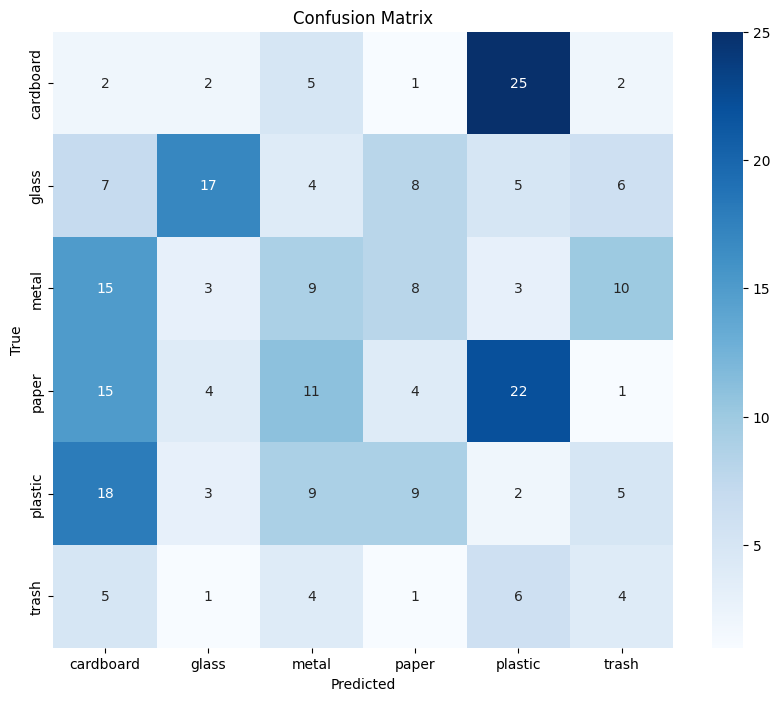

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


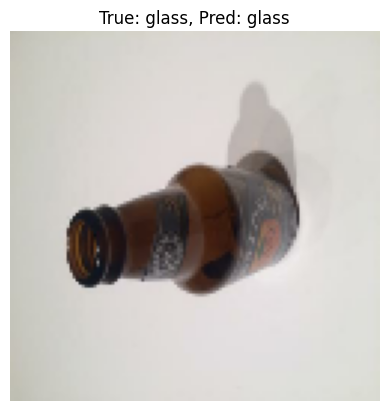

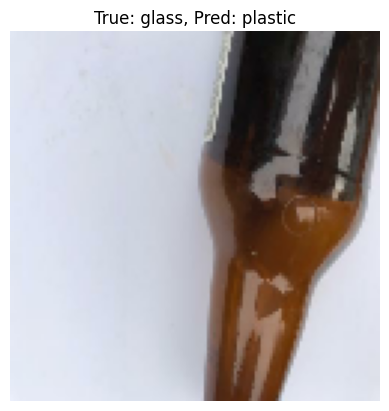

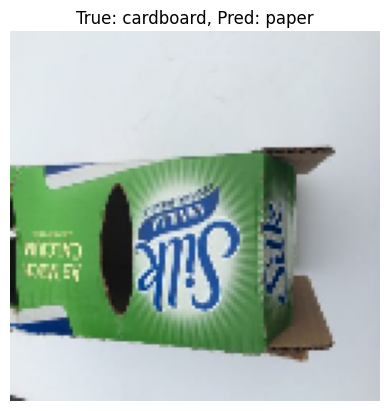

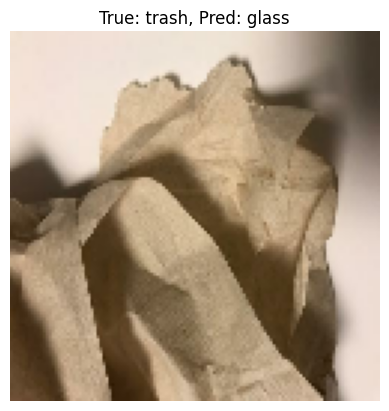

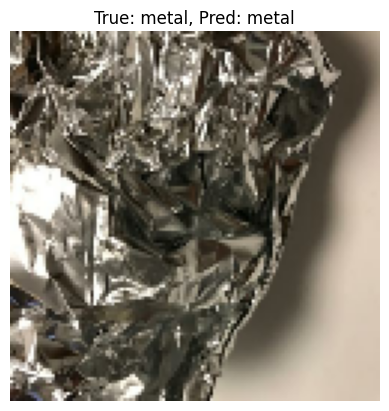

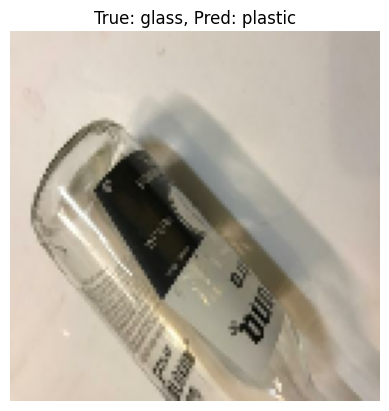

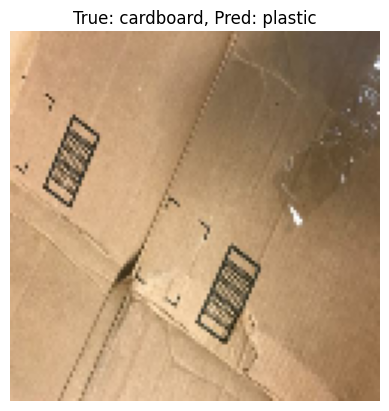

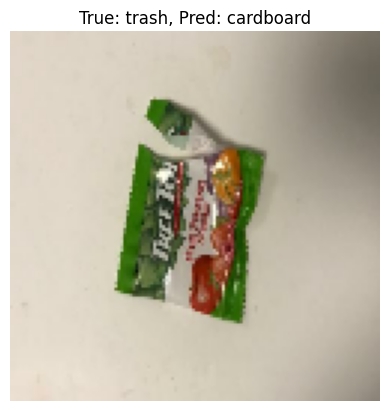

In [32]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title


In [34]:
!pip install gradio

In [35]:
model.save('Efficientnetv2b2.keras')
model = tf.keras.models.load_model('Efficientnetv2b2.keras')


In [36]:

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [37]:
def classify_image(img):  

    img = img.resize((124, 124))  
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  
    prediction = model.predict(img_array)  
    predicted_class_index = np.argmax(prediction)  
    predicted_class_name = class_names[predicted_class_index]  

    confidence = prediction[0][predicted_class_index]  
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})" 

In [38]:
iface = gr.Interface(  
    fn=classify_image,  
    inputs=gr.Image(type="pil"), 
    outputs="text" 
)  


iface.launch() 

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
